In [37]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
frame = pd.read_csv('final_data/finalframe.csv',sep=';',index_col=[0])

In [38]:
random_seed = 1

In [39]:
np.isin(frame.index,[pd.to_datetime(x) for x in ('2020-05-01',
'2020-06-01',
'2015-03-01')])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [40]:
frame = frame.loc[~np.isin(frame.index,[x for x in ('2020-05-01',
'2020-06-01',
'2015-03-01')]),:]

In [41]:
len(frame)

86

In [42]:
X = frame.iloc[:,0:len(frame.columns)-1]

In [43]:
y = frame.iloc[:,len(frame.columns)-1]

In [44]:
#X['month'] = list((pd.Series(X.index).str.split('-',expand=True).loc[:,1] == '07')*100)

In [45]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X)
X.columns = scaler.get_feature_names_out()

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=random_seed,test_size=.2)

In [48]:
from sklearn.linear_model import ElasticNet

In [49]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

In [50]:
model =ElasticNet(max_iter=100000,alpha=.02,)

In [51]:
model = model.fit(X_train,y_train)

In [52]:
model.predict(X_test)

array([0.64918603, 0.80556424, 0.7308641 , 1.47629394, 0.95031828,
       2.63267054, 1.1173232 , 2.9195654 , 1.99121578, 0.47376828,
       2.80264469, 0.14682914, 1.21613407, 2.01056521, 0.74558856,
       3.02100301, 2.75449201, 1.06806755])

In [53]:
y_test.to_numpy()

array([0.63114515, 0.84131742, 0.70150343, 1.88872843, 1.05374552,
       2.29685846, 1.76765165, 2.50766809, 0.45543704, 0.17017025,
       2.40897739, 0.33032583, 0.9024204 , 1.74923241, 0.23856367,
       2.81571215, 3.28426841, 1.01346991])

In [54]:
mae(y_train,model.predict(X_train))

0.09983949254481589

In [55]:
mae(y_test,model.predict(X_test))

0.34918507273334937

In [56]:
mape(y_test,model.predict(X_test))

0.5496314598180225

In [59]:
def month_error(model,X_test,y_test):
    myframe = pd.DataFrame([y_test.to_numpy(),model.predict(X_test)],columns=y_test.index).T
    myframe = pd.DataFrame(y_test.to_numpy()-model.predict(X_test),index=y_test.index).abs()
    myframe['mes'] = pd.Series(myframe.index).str.split('-').apply(lambda x: x[1]).to_numpy()
    
    return myframe.groupby('mes').sum()

In [60]:
me_enet = month_error(model,X_test,y_test).rename({0:'ElasticNet_Error'},axis=1)
me_enet

,ElasticNet_Error
mes,
01,0.466495
02,0.752953
04,0.547817
05,0.029361
06,0.412434
07,2.226300
10,0.600684
11,0.393667
12,0.855619


In [61]:
coefs = pd.DataFrame(zip(np.array(X_train.columns),model.coef_),columns=['Variable','Coef'])

In [62]:
(coefs[coefs['Coef'] != 0]).sort_values('Coef',ascending=False)

,Variable,Coef
667,5442_sma3_sma6_o1,0.107210
877,24387_e2_sma3_sma12_o1,0.101080
809,BM12_NFSPNNAS12_e2_sma3_sma6_sma12_o1,0.092028
719,28556_e2_sma3_sma12,0.074889
729,4735_sma3,0.072133
...,...,...
609,1373_sma6_sma12,-0.048252
636,5013_e2_sma3,-0.049270
360,5457_e2,-0.063819
371,21941_e2_sma6,-0.113913


In [63]:
cof = (coefs[coefs['Coef'] != 0]).sort_values('Coef',ascending=False)

In [64]:
cof['Serie'] = cof['Variable'].str.split('_',expand=True)[0]

In [65]:
bcb_md = pd.read_csv('data/bcb_metadata.csv',encoding='latin-1',sep=';')

In [66]:
mvars = cof.merge(bcb_md.astype(str),how='left',left_on='Serie',right_on='Codigo')[['Variable','Nome','Coef']]

In [67]:
mvars.head(5)

,Variable,Nome,Coef
0,5442_sma3_sma6_o1,NFSP sem desvalorização cambial (% PIB) - Flux...,0.107210
1,24387_e2_sma3_sma12_o1,Rendimento médio real habitual das pessoas ocu...,0.101080
2,BM12_NFSPNNAS12_e2_sma3_sma6_sma12_o1,NaN,0.092028
3,28556_e2_sma3_sma12,Número de horas trabalhadas  indústria de tra...,0.074889
4,4735_sma3,NFSP sem desvalorização cambial - Fluxo acumul...,0.072133


In [68]:
for x in mvars['Nome'].head(5):
    print(x)

NFSP sem desvalorização cambial (% PIB) - Fluxo acumulado no ano - Resultado nominal - Interna - Governo Federal e Banco Central
Rendimento médio real habitual das pessoas ocupadas - Conta própria - PNADC
nan
Número de horas trabalhadas  indústria de transformação (2016=100) - Dados dessazonalizados
NFSP sem desvalorização cambial - Fluxo acumulado no ano - Resultado nominal - Interna - Empresas estatais estaduais


In [69]:
mvars.tail(5)

,Variable,Nome,Coef
59,1373_sma6_sma12,Produção total de autoveículos,-0.048252
60,5013_e2_sma3,NFSP sem desvalorização cambial - Fluxo acumul...,-0.049270
61,5457_e2,NFSP sem desvalorização cambial (% PIB) - Flux...,-0.063819
62,21941_e2_sma6,Produção Industrial (2012=100) - Geral - Com a...,-0.113913
63,1508_e2_sma12,Índice de volume de vendas no varejo - Hiper/s...,-0.152508


In [70]:
for x in mvars['Nome'].tail(5):
    print(x)

Produção total de autoveículos
NFSP sem desvalorização cambial - Fluxo acumulado em 12 meses - Resultado nominal - Interna - Governo Federal e Banco Central
NFSP sem desvalorização cambial (% PIB) - Fluxo acumulado no ano - Resultado nominal - Externa - Governos estaduais
Produção Industrial (2012=100) - Geral - Com ajuste sazonal - Goiás
Índice de volume de vendas no varejo - Hiper/supermercado, prod.alimentícios, bebidas, fumo - Distrito Federal


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(-10.0, 0, '2021-06-01'),
  Text(0.0, 0, '2014-10-01'),
  Text(10.0, 0, '2016-02-01'),
  Text(20.0, 0, '2016-12-01'),
  Text(30.0, 0, '2017-11-01'),
  Text(40.0, 0, '2019-03-01'),
  Text(50.0, 0, '2020-04-01'),
  Text(60.0, 0, '2021-09-01'),
  Text(70.0, 0, ''),
  Text(80.0, 0, '')])

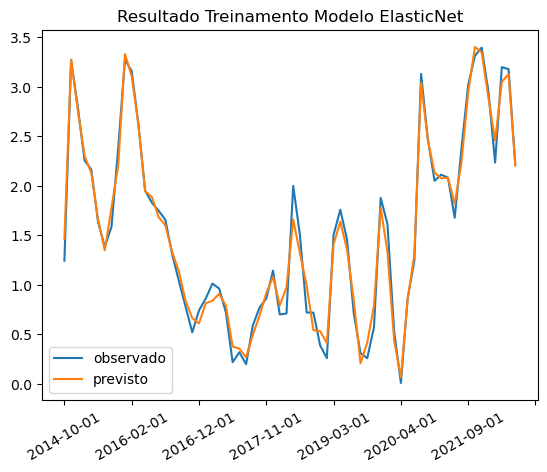

In [71]:
pd.DataFrame({'observado':y_train,'previsto':model.predict(X_train)}).sort_index().plot()
plt.title('Resultado Treinamento Modelo ElasticNet')
plt.xticks(rotation=30)

Text(0.5, 1.0, 'Validação Resultado Modelo ElasticNet')

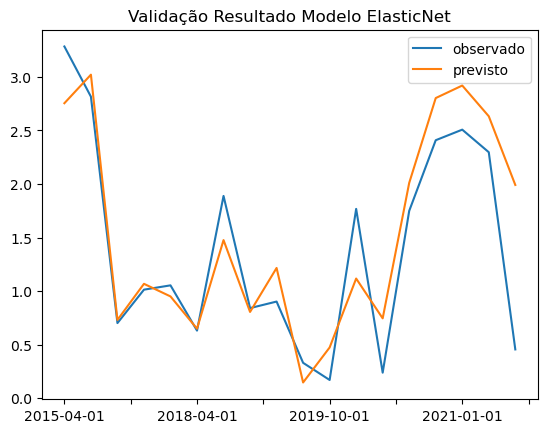

In [72]:
pd.DataFrame({'observado':y_test,'previsto':model.predict(X_test)}).sort_index().plot()
y_test_comp = {'observado':y_test,'ElasticNet':model.predict(X_test)}
plt.title('Validação Resultado Modelo ElasticNet')

In [73]:
import sklearn.neural_network as nn

In [74]:
m = nn.MLPRegressor(activation='tanh',hidden_layer_sizes=(35,10,2),random_state=random_seed,max_iter=1000000,alpha=.01)

In [75]:
m.fit(X_train,y_train)

MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(35, 10, 2),
             max_iter=1000000, random_state=1)

In [76]:
mae(y_train,m.predict(X_train))

0.18793171191612743

In [77]:
mae(y_test,m.predict(X_test))

0.32190519372099824

In [78]:
mape(y_test,m.predict(X_test))

0.447121372947103

In [79]:
nfeat = (len(X_train.columns)*35 +
len(X_train.columns)*10+len(X_train.columns)*2)

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(-10.0, 0, '2021-06-01'),
  Text(0.0, 0, '2014-10-01'),
  Text(10.0, 0, '2016-02-01'),
  Text(20.0, 0, '2016-12-01'),
  Text(30.0, 0, '2017-11-01'),
  Text(40.0, 0, '2019-03-01'),
  Text(50.0, 0, '2020-04-01'),
  Text(60.0, 0, '2021-09-01'),
  Text(70.0, 0, ''),
  Text(80.0, 0, '')])

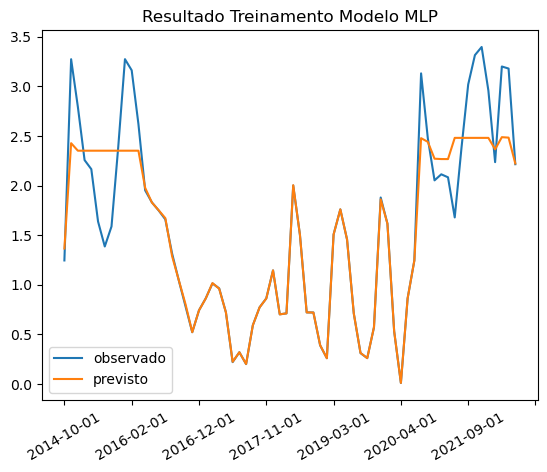

In [81]:
pd.DataFrame({'observado':y_train,'previsto':m.predict(X_train)}).sort_index().plot()
plt.title('Resultado Treinamento Modelo MLP')
plt.xticks(rotation=30)

Text(0.5, 1.0, 'Validação Resultado Modelo MLP')

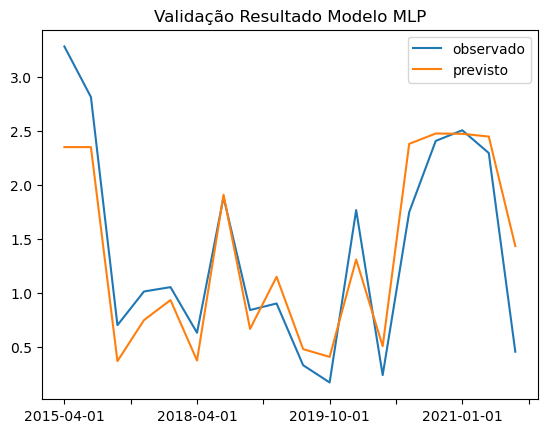

In [82]:
pd.DataFrame({'observado':y_test,'previsto':m.predict(X_test)}).sort_index().plot()
y_test_comp['MLP'] = m.predict(X_test)
plt.title('Validação Resultado Modelo MLP')

In [83]:
me_mlp = month_error(m,X_test,y_test).rename({0:'MLP_Error'},axis=1)
me_mlp

,MLP_Error
mes,
01,0.298427
02,0.519273
04,1.190006
05,0.333525
06,0.021567
07,1.396558
10,1.044046
11,0.068817
12,0.922076


In [84]:
from catboost import CatBoostRegressor

In [85]:
m = CatBoostRegressor(iterations=50000,learning_rate=1,depth=2,l2_leaf_reg=100000,random_state=random_seed)

In [86]:
m.fit(X_train,y_train)

0:	learn: 0.9533714	total: 70.8ms	remaining: 58m 59s
1:	learn: 0.9532100	total: 78.5ms	remaining: 32m 41s
2:	learn: 0.9530232	total: 100ms	remaining: 27m 53s
3:	learn: 0.9528511	total: 105ms	remaining: 21m 55s
4:	learn: 0.9527255	total: 109ms	remaining: 18m 11s
5:	learn: 0.9525193	total: 113ms	remaining: 15m 43s
6:	learn: 0.9523505	total: 117ms	remaining: 13m 55s
7:	learn: 0.9522095	total: 121ms	remaining: 12m 33s
8:	learn: 0.9520679	total: 124ms	remaining: 11m 27s
9:	learn: 0.9519265	total: 127ms	remaining: 10m 34s
10:	learn: 0.9517850	total: 130ms	remaining: 9m 51s
11:	learn: 0.9516436	total: 133ms	remaining: 9m 15s
12:	learn: 0.9515022	total: 136ms	remaining: 8m 44s
13:	learn: 0.9513355	total: 139ms	remaining: 8m 16s
14:	learn: 0.9511689	total: 142ms	remaining: 7m 53s
15:	learn: 0.9510023	total: 145ms	remaining: 7m 33s
16:	learn: 0.9508358	total: 148ms	remaining: 7m 15s
17:	learn: 0.9506693	total: 151ms	remaining: 6m 59s
18:	learn: 0.9505029	total: 154ms	remaining: 6m 44s
19:	learn:

In [87]:
m.predict(X_test)

array([0.73662913, 0.89019144, 0.66690999, 1.43021205, 0.89311399,
       2.65324558, 1.07851913, 2.60440551, 2.03265207, 0.38396268,
       2.43784715, 0.55232575, 0.64639479, 1.66126769, 0.93656529,
       2.65732317, 2.89929103, 0.93034542])

In [88]:
mae(y_test,m.predict(X_test))

0.3144842405647164

In [89]:
mae(y_train,m.predict(X_train))

0.07197889284461911

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.]),
 [Text(-10.0, 0, '2021-06-01'),
  Text(0.0, 0, '2014-10-01'),
  Text(10.0, 0, '2016-02-01'),
  Text(20.0, 0, '2016-12-01'),
  Text(30.0, 0, '2017-11-01'),
  Text(40.0, 0, '2019-03-01'),
  Text(50.0, 0, '2020-04-01'),
  Text(60.0, 0, '2021-09-01'),
  Text(70.0, 0, ''),
  Text(80.0, 0, '')])

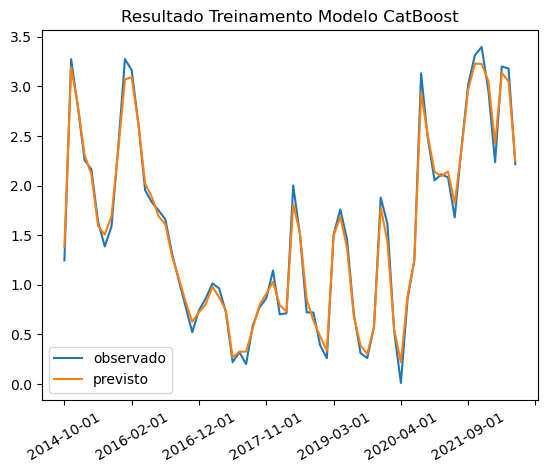

In [90]:
pd.DataFrame({'observado':y_train,'previsto':m.predict(X_train)}).sort_index().plot()
plt.title('Resultado Treinamento Modelo CatBoost')
plt.xticks(rotation=30)

Text(0.5, 1.0, 'Validação Resultado Modelo CatBoost')

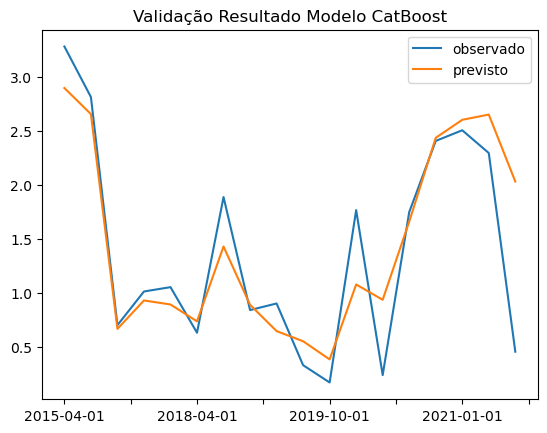

In [91]:
pd.DataFrame({'observado':y_test,'previsto':m.predict(X_test)}).sort_index().plot()
y_test_comp['CatBoost'] = m.predict(X_test)
plt.title('Validação Resultado Modelo CatBoost')

In [92]:
me_cb = month_error(m,X_test,y_test).rename({0:'CatBoost_Error'},axis=1)
me_cb

,CatBoost_Error
mes,
01,0.179862
02,0.773044
04,0.490461
05,0.034593
06,0.458516
07,2.497217
10,0.350631
11,0.028870
12,0.847522


In [93]:
merror = pd.concat([me_enet,me_mlp,me_cb],axis=1)

Text(0.5, 1.0, 'Erro Acumulado por Mês')

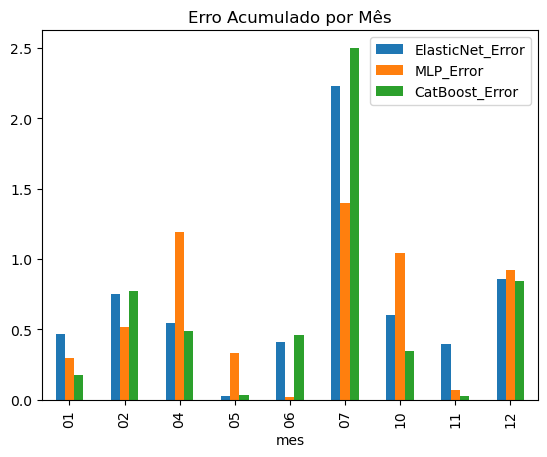

In [94]:
merror.plot(kind='bar')
plt.title("Erro Acumulado por Mês")

Text(0.5, 1.0, 'MAE dos Modelos nos Dados de Teste')

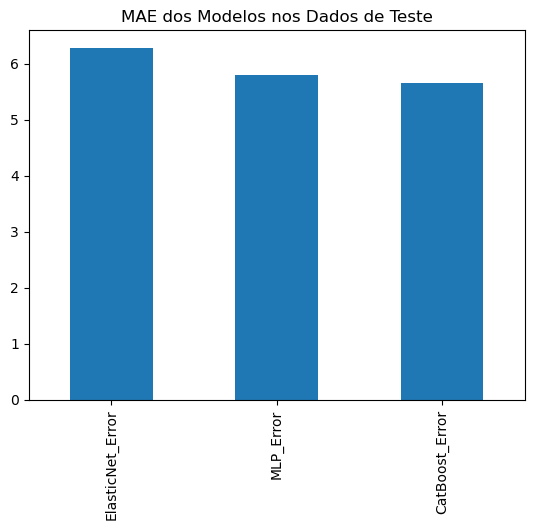

In [95]:
merror.sum().sort_values(ascending=False).plot(kind='bar')
plt.title("MAE dos Modelos nos Dados de Teste")

In [101]:
ematrix = (merror.sum().sort_values(ascending=False)/len(X_test))

Text(1.87, 0.2994842405647164, '0.314')

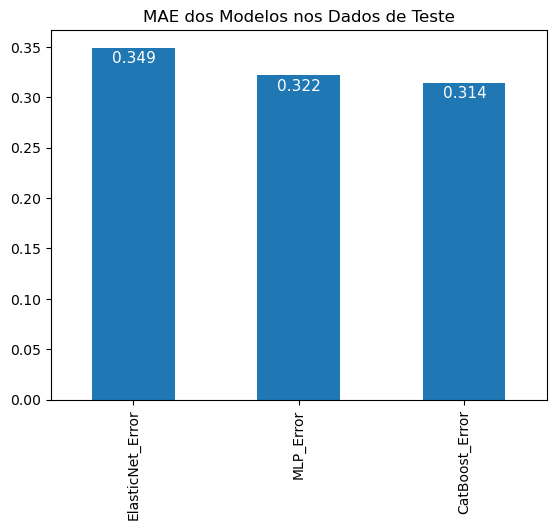

In [125]:
ematrix.plot(kind='bar')
plt.title("MAE dos Modelos nos Dados de Teste")
d = list(ematrix.index)[0]
plt.annotate(round(ematrix[d],3),[-0.13,ematrix[d]-0.015],size=11,color='white')
d = list(ematrix.index)[1]
plt.annotate(round(ematrix[d],3),[0.87,ematrix[d]-0.015],size=11,color='white')
d = list(ematrix.index)[2]
plt.annotate(round(ematrix[d],3),[1.87,ematrix[d]-0.015],size=11,color='white')

Text(0.5, 1.0, 'Comparação Valores Observados com Previstos pelos Modelos')

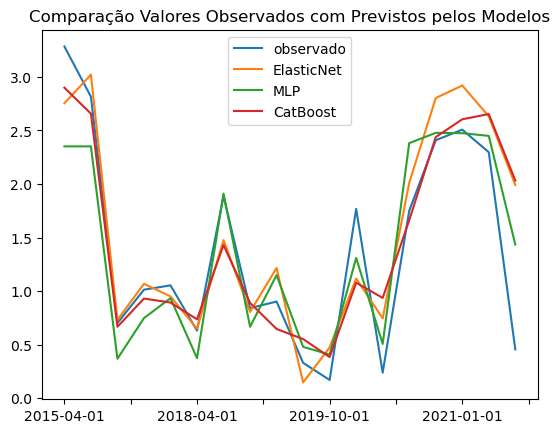

In [141]:
pd.DataFrame(y_test_comp).sort_index().plot()
plt.title('Comparação Valores Observados com Previstos pelos Modelos')

In [134]:
pd.DataFrame(y_test_comp).sort_index()

,observado,ElasticNet,MLP,CatBoost
2015-04-01,3.284268,2.754492,2.351588,2.899291
2015-12-01,2.815712,3.021003,2.351588,2.657323
2017-05-01,0.701503,0.730864,0.367979,0.666910
2018-01-01,1.013470,1.068068,0.748005,0.930345
2018-02-01,1.053746,0.950318,0.934105,0.893114
2018-04-01,0.631145,0.649186,0.373820,0.736629
2018-06-01,1.888728,1.476294,1.910295,1.430212
2018-10-01,0.841317,0.805564,0.666819,0.890191
2019-02-01,0.902420,1.216134,1.149503,0.646395
2019-07-01,0.330326,0.146829,0.479408,0.552326


In [135]:
y_test_comp_errors = pd.DataFrame(y_test_comp)


In [136]:
for f in range(1,4):
    col = y_test_comp_errors.columns[f]
    print(col)
    y_test_comp_errors.loc[:,col] = y_test_comp_errors['observado'] - y_test_comp_errors[col]

ElasticNet
MLP
CatBoost


In [137]:
y_test_comp_errors.drop('observado',axis=1,inplace=True)

<AxesSubplot:>

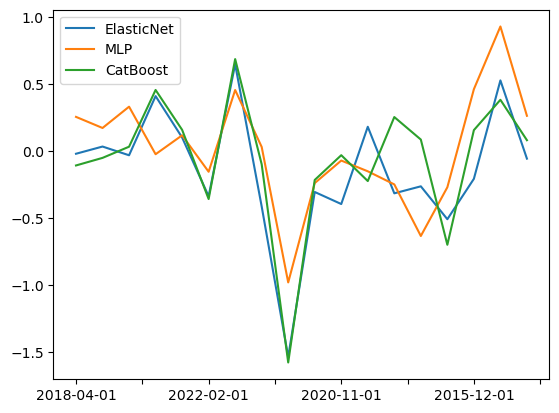

In [138]:
y_test_comp_errors.plot()

Text(0.5, 1.0, 'Erros dos modelos')

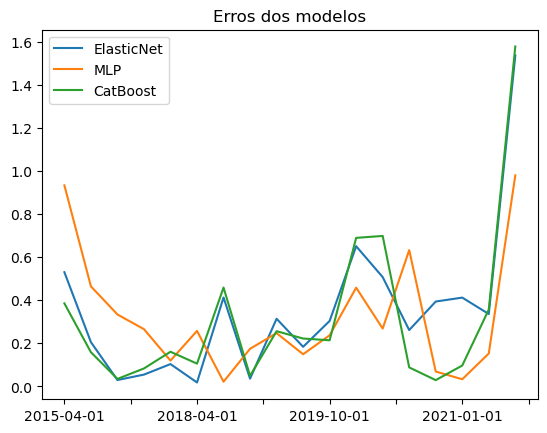

In [140]:
y_test_comp_errors.abs().sort_index().plot()
plt.title("Erros dos modelos")

In [154]:
temp = y_test_comp_errors.abs().sort_index()

In [155]:
for cn in range(0,len(temp.columns)):

    p = 0
    vac = 0
    col = temp.iloc[:,cn]

    for p in range(0,len(col)):
        col[p] = (col[p]+vac)/(p+1)
        vac = vac+col[p]

    temp.loc[:,temp.columns[cn]] = col


In [ ]:
cof = pd.DataFrame(m.get_feature_importance(),index=m.feature_names_,columns=['importance']).sort_values(by='importance',ascending=False)

In [ ]:
cof

,importance
1567_e2_sma3_sma6_sma12,14.456713
256_sma3_sma6_sma12,9.672493
1420_e2_sma12,7.689788
5045_e2_sma3_sma6_sma12_o1,7.468825
28771_e2_sma3_sma6_sma12,7.215101
...,...
17661_e2_sma6_sma12,0.000000
5035_e2_sma6_sma12_o1,0.000000
5003_sma3_sma12,0.000000
4755_sma6_sma12_o1,0.000000


In [ ]:
cof = cof.reset_index().rename({"index":'Serie'},axis=1)

In [ ]:
cof['Serie'] = list(pd.Series(cof.loc[:,'Serie']).str.split('_',expand=True)[0])

In [ ]:
cof

,Serie,importance
0,1567,14.456713
1,256,9.672493
2,1420,7.689788
3,5045,7.468825
4,28771,7.215101
...,...,...
878,17661,0.000000
879,5035,0.000000
880,5003,0.000000
881,4755,0.000000


In [ ]:
bcb_md = pd.read_csv('data/bcb_metadata.csv',encoding='latin-1',sep=';')

In [ ]:
bcb_md

,Codigo,Nome,Unidade,Periodo,Inicio,Ultimo,Fonte,Especial
0,1544,Índice volume de vendas no varejo (2000=100) -...,Índice,M,31/01/2000,01/12/2003,IBGE,N
1,108,BTN/UFIR mensal,u.m.c.,M,28/02/1989,01/09/2000,Sisbacen PTAX860,N
2,109,Fundo de aplicações financeiras - Aplicações e...,u.m.c. (mil),M,30/04/1991,01/11/1995,Sisbacen PFAF300,N
3,110,Fundo de aplicações financeiras - Aplicações e...,u.m.c. (mil),M,30/04/1991,01/11/1995,Sisbacen PFAF300,N
4,111,Fundo de aplicações financeiras - Aplicações e...,u.m.c. (mil),M,30/04/1991,01/11/1995,Sisbacen PFAF300,N
...,...,...,...,...,...,...,...,...
11663,29038,Endividamento das famílias com o Sistema Finan...,%,M,01/01/2005,01/03/2022,BCB-DSTAT,N
11664,29039,Índice de Commodities - Brasil - Energia (em U...,Índice,M,31/01/1998,01/07/2022,BCB-Depec,N
11665,29040,Índice de Commodities - Brasil - Metal (em US ...,Índice,M,31/01/1998,01/07/2022,BCB-Depec,N
11666,29041,Índice de Commodities - Brasil - Agropecuária ...,Índice,M,31/01/1998,01/07/2022,BCB-Depec,N


In [ ]:
cof.merge(bcb_md.astype(str),how='left',left_on='Serie',right_on='Codigo')[['Nome','importance']].head(5)

,Nome,importance
0,Índice volume de vendas no varejo - Hipermerca...,14.456713
1,Taxa de juros de longo prazo - TJLP,9.672493
2,Consumo de energia elétrica - Região Sul - Outros,7.689788
3,NFSP sem desvalorização cambial - Fluxo acumul...,7.468825
4,Estoque de empregos formais  Comércio,7.215101
